In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Interpolations
using DSP
using FFTW
using NCDatasets
using JLD2
using Printf

# include("./readers.jl")
include("./read_lidar.jl")
using .read_lidar
using .read_lidar.stare
# using MAT

using PyPlot

  Activating project at `~/Projects/ASTRAL/lidar`


In [2]:
# utility functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

"bin average y(x) in bins b of coordinate x"
function binavg(y, x, b)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b)
        a[bi] += y[i]
        c[bi] += 1
    end
    return a./c
end

# functions for masking and averaging data

"NaN -> missing"
n2m(x) = isfinite.(x) ? x : missing

"result is x; set to missing iff i<thr"
masklowi(x, i, thr=1.03) = i<thr ? missing : x

"mean along dimension dims, skipping missing"
missmean(X; dims=1) = mapslices(x -> mean(skipmissing(x)), X, dims=dims)

"anomaly"
anom(x; dims=1) = x.-mean(x; dims=dims)

# highpass filter
"""
hp(x, fcutoff=1/80)    highpass filter x,
by default filtfilt 4th-order Butterworth, fs=1
"""
function hp(x, fcutoff=1/80;
    order=4,
    designmethod=Butterworth(order), 
    fs=1,
    responsetype = Highpass(fcutoff; fs=fs) )
    
    filtfilt(digitalfilter(responsetype, designmethod), x)
end


# make simple linear temporal interpolation
# maybe fast
# most time is spent searching for indices
# indices are monotonic

"return all the indices i such that each xl[i] is the first >= each xs."
# untested suggestion:
# findindices(xs, xl) = [ findfirst(xl .>= x) for x in xs ]
function findindices(xs, xl)
    # xs needles define quarries in haystack xl
    xs = filter(x -> x<=last(xl), xs) # prefilter to avoid running off the end of xl
    ind = zeros(Int64, size(xs))
    i = 1
    for (j,x) in enumerate(xs)
        while xl[i] < x
            i += 1
        end
        ind[j] = i
    end
    return ind
end


# # remove old method for centered average - SPd 2024-11-11
# "average xl centered within +-half points of the index of xl"
# function indavg(xl, ind; half=10)
#     xm = zeros(Float64, size(ind))
#     for (i,idx) in enumerate(ind)
#         ii = max(1,idx-half) : min(length(xl),idx+half)
#         xm[i] = sum(Float64.(xl[ii])) / (2*half+1)
#     end
#     return xm
# end
# # replace with average to right of ind
"average xl within windows to right of points of the index ind of xl"
function indavg(xl, ind; full=20)
    xm = zeros(Float64, size(ind))
    for (i,idx) in enumerate(ind)
        ii = max(1,idx) : min(length(xl),idx+full)
        # xm[i] = sum(Float64.(xl[ii])) / (full+1)
        xm[i] = mean(Float64.(xl[ii]))
    end
    return xm
end

# test data (precompiles)
let xl = 1:60_000_000, xs = 20:20:60_000_000
    ind = findindices(xs, xl)
    indavg(xl, ind)
end

# Adjust true vertical velocity for relative wind * sin(tilt)
# and the platform velocity
trigs(pitch, roll) = ( cos(pitch), sin(pitch), cos(roll), sin(roll) )
# cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)

function wtrue(w, Ur, Vr, pitch, roll)
    cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)
    wtrue = ( w + Ur*sinpitch - Vr*cospitch*sinroll ) / (cospitch*cosroll)
end

# displacements with no adjustment for tilting into the horizontal wind 
# U, V vary slowly; pitch,roll,w vary fast
# there are nt*(nt-1)/2 ~ O(nt^2) outputs, so correct stuff first

## don't use:
# "return the coherent component of signal1 and signal2"
# function coherent_component(signal1::Vector{Float64}, signal2::Vector{Float64})
#     # Fourier Transform of the signals
#     S1 = fft(signal1)
#     S2 = fft(signal2)
    
#     # Compute cross-spectral density
#     P12 = S1 .* conj(S2)
#     # P21 = conj(P12)
    
#     # Compute auto-spectral density
#     P11 = S1 .* conj(S1)
#     P22 = S2 .* conj(S2)
    
#     # Compute coherence
#     coherence = abs.(P12).^2 ./ (P11 .* P22)
    
#     # Compute the coherent part
#     coherent_part_S1 = coherence .* S2
#     coherent_part_S2 = coherence .* S1
    
#     # Inverse Fourier Transform to get the time-domain signals
#     coherent_signal1 = real(ifft(coherent_part_S1))
#     coherent_signal2 = real(ifft(coherent_part_S2))
    
#     return coherent_signal1, coherent_signal2
# end

# "remove the coherent component of signal1 and signal2"
# function remove_coherent_component(signal1::Vector{Float64}, signal2::Vector{Float64})
#     # Fourier Transform of the signals
#     S1 = fft(signal1)
#     S2 = fft(signal2)
    
#     # Compute cross-spectral density
#     P12 = S1 .* conj(S2)
#     # P21 = conj(P12)
    
#     # Compute auto-spectral density
#     P11 = S1 .* conj(S1)
#     P22 = S2 .* conj(S2)
    
#     # Compute coherence
#     coherence = abs.(P12).^2 ./ (P11 .* P22)
    
#     # Compute the coherent part
#     coherent_part_S1 = coherence .* S2
#     coherent_part_S2 = coherence .* S1
    
#     # Remove the coherent part
#     clean_S1 = S1 .- coherent_part_S1
#     clean_S2 = S2 .- coherent_part_S2
    
#     # Inverse Fourier Transform to get the time-domain signals
#     clean_signal1 = real(ifft(clean_S1))
#     clean_signal2 = real(ifft(clean_S2))
    
#     return clean_signal1, clean_signal2
# end

wtrue (generic function with 1 method)

In [3]:
# functions for structure functions

# generate unique pairs of indices
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# beam geometry
"lidar beam range"
rng(iz, rangegate=24.0) = rangegate * (iz-1 + 0.5)

"""
compile indices of lidar volumes to be compared with
structure functions
"""
function lidarindices(nt, nz, z1=1; nlevelstats=1)
    if nlevelstats == 3
        # The complete set that doesn't repeat pairs is 
        # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
        # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
        # Iteratively slide this box upward by 1 level for each level.
    
        # index pairs in middle level 2-2
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r22 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r22 = CartesianIndex.(tuple.(it2,z1)) # 2nd 
    
        # index pairs of points from level 2-1, and 2-3
        ac = allcross(nt)
        it1 = map(i->i[1], ac)
        it2 = map(i->i[2], ac)
        ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
        ci2_r21 = CartesianIndex.(tuple.(it2,z1-1))
        ci2_r23 = CartesianIndex.(tuple.(it2,z1+1))
    
        # omnibus set of cartesian index pairs for a level, including points in lev above and below
        ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
        ci2 = [ci2_r23; ci2_r22; ci2_r21]
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
        
    elseif nlevelstats == 1
        # just use structure function velocity pairs from one level of lidar range
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r11 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r11 = CartesianIndex.(tuple.(it2,z1)) # 2nd point in same lev
    
        # set of cartesian index pairs for a level, including points in lev above and below
        ci1 = ci1_r11 # first of pairs
        ci2 = ci2_r11
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
    end
    
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second
    
    return ci1,ci2, li1,li2, it1,iz1,it2,iz2
end

# try example
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(1000, 80)


(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1)  …  CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(996, 1), CartesianIndex(997, 1), CartesianIndex(997, 1), CartesianIndex(997, 1), CartesianIndex(998, 1), CartesianIndex(998, 1), CartesianIndex(999, 1)], CartesianIndex{2}[CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1), CartesianIndex(11, 1)  …  CartesianIndex(997, 1), CartesianIndex(998, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(998, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(999, 1), CartesianIndex(1000, 1), CartesianIndex(1000, 1)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 1

In [4]:
# displacments and structure functions 

rangegate = 24.0 # for ASTRAL 2024 Halo Photonics StreamLineXR

"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate , timestep=timestep)
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # CORRECT W for HEAVE and for TILTING into the horizontal wind
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

In [5]:
# moved to read_lidar.jl: utilities for requesting, reading, and subsetting data from files 

#=
# stare functions to find and use start and end indices of stare chunks

module stare

# used in read_lidar_chunks and tests
export hour_beams
export all_gaps
export all_start_end_indices
export query_start_end_chunks
export all_chunks

# Request chunk subscripts and start and end times in any time window.
"return time as a decimal hour from the start time"
function hour_beams(time, ibeam1, start_time)
    # time is decimal hour of the day
    # ibeam1 is the index of time corresponding to start_time
    # start_time is the DateTime when a new file starts
    
    # expand time axis to include day and decimal hour
    ibeam_expand = [ findlast( ibeam1 .<= i ) for i in eachindex(time) ]
    dtbeams = @. floor(start_time, Day)[ibeam_expand] 
    hourbeams = @. 24*Dates.value(Day(dtbeams-dtbeams[1])) + time
end
"hour_beams(timeangles::Dict)"
hour_beams(ta::Dict) = hour_beams(ta[:time], ta[:ibeam1], ta[:start_time])

# identify indices of chunks from gaps
function all_gaps(t)
    ien = findall( diff(t) .> 0.01 ) # gap of more than a few tens of seconds
    ist = ien .+ 1 # start of the next chunk
    return ien, ist
end

function all_start_end_indices(ien, ist)
    # ii increasing-order vector of all start and end indices
    ii = sort( permutedims([ien ist])[:] ) # ordered; this should sort them, but sort() for good measure
    jj = LinearIndices(ii) # jj indexes ii
    # ii alternates end start-end ... start ii[jjen] == ien; ii[jjst] == ist
    jjen = jj[1:2:end]
    jjst = jj[2:2:end] # even starts of next chunks follow previous odd ends
    # NOTE: a view can change the parity of starts and ends
    return ii,jj, jjen,jjst
end
# ii is the big array of start and end indices

# functions to check if an index i is an end point; or a start point
isend(i) = in(i, Ref(ien)) # Boolean true for interval chunk end points of ii
isstart(i) = in(i, Ref(ist)) # Boolean true for interval chunk start points of ii

# NOTE ii default is computed by all_start_end_indices, but not available in the lexical scope
# so ii MUST be provided in the call

# end index corresponding to a start indes
# get the index j such that i = ii[j]
thisj(i, ii) = findfirst(ii.==i)
# get the end index ien corresponding to the start index ist of the same chunk
chunken(ist, ii) = ii[thisj(ist, ii) + 1]
# get the start index ist corresp to the end index ien of the same chunk
chunkst(ien, ii) = ii[thisj(ien, ii) - 1]

# index the next chunk
nextchunki(i, ii) = ii[thisj(i, ii) + 2]
# index the previous chunk
prevchunki(i, ii) = ii[thisj(i, ii) - 2]

# Find chunks within query start and end times.
"""
Request start and end chunks based on time indices.
Inclusive: include chunks for which query falls in the middle.
"""
function query_start_end_chunks(qst, qen; ien=ien, ist=ist)
    ien1 = ien[findfirst(x-> x>=qst , ien)] # end index of first queried chunk     # do in this order
    ist1 = ist[findlast( x-> x <ien1, ist)] # start index of first queried chunk
    lastist = ist[findlast( x-> x<=qen   , ist)] # start index of last queried chunk
    lastien = ien[findfirst(x-> x>lastist, ien)] # end index of last queried chunk
    ist1,ien1, lastist,lastien
end

"""
request all start indices and all end indices between 
index of start of first chunk and end of last chunk lastien
"""
function all_chunks(ist1, lastien, ii)
    # pickets of queried subset
    iisub = ii[ findall(x-> ist1<=x<=lastien, ii) ] # start-end ... start-end ; no orphans

    istsub = iisub[1:2:end] # iisub parity switched from ii
    iensub = iisub[2:2:end] # even ends follow odd starts of same chunk
    return istsub, iensub # start-end pairs
end

end # module stare

using .stare
=#

In [6]:
## utility functions to determine which file a chunk is in and its indices in that file

# !MOVE utilities for requesting, reading, and subsetting data from files
# TO read_lidar.jl
# include("read_lidar.jl")

# internal functions:
# get_stare_files, thisfile_idx, idx_beams_in_file, thisfile_start_end, thisfile_name
# export read_lidar_chunks # used
# export get_all_file_start_end_idxs # exported to test

# time index hierarchy:
#     beam
#   stare chunk [start, end]
# file [start, end]

# Collect data start indices times of all files in ibeam1
# number of beams in each file nbeam
# so last beam index in a file is ibeam1+nbeam-1
# get_start_fileidx(tidx) = findlast(t-> ibeam1<=t, tidx)
# get_end_fileidx(tidx) = findfirst(t-> ibeam1+nbeam-1>=t, tidx)
get_stare_files(tidx, files) = files[get_fileidx(tidx)]

# vectors of all file start and end indices
function get_all_file_start_end_idxs(ta::Dict)
    fi1 = ta[:ibeam1][:]
    filast = @. fi1 + ta[:nbeams] - 1
    return fi1, filast
end
function get_all_file_start_end_idxs(file_paths) 
    ta = read_streamlinexr_beam_timeangles(file_path)
    get_all_file_start_end_idxs(ta)
end

"index of the file for which the index x falls between fi1 and filast"
thisfile_idx(x, fi1, filast) = findfirst( fi1.<= x .<=filast)

# this method superseded by one that uses fi1, filast in calling scope
idx_beams_in_file(i, ibeam1, fi1, filast) = i - ibeam1[thisfile_idx(i, fi1, filast)] + 1

function thisfile_start_end(x, fi1, filast)
    j = thisfile_idx(x, fi1, filast)
    return fi1[j], filast[j]
end

"get name of a file corresponding to a time or index"
thisfile_name(x::Integer, fi1, filast, files=fullfiles) = files[thisfile_idx(x, fi1, filast)]
function thisfile_name(dtx::DateTime, dt::Vector{DateTime}, files=fullfiles) 
    fi1, filast = get_all_file_start_end_idxs(files)
    thisfile_name( findlast(dt .<= dtx), fi1, filast, files)
end

"read chunks inclusive between [firstdtq lastdq] from vector of files"
function read_lidar_chunks(files, firstdtq, lastdtq)
    # read all times
    ta, hdr, nbeams = read_lidar.read_streamlinexr_beam_timeangles(files) # 5 s per day

    # TODO append day hour to the decimal hour...
    hdr[:start_time]
    # finding indices
    ien, ist = all_gaps(ta[:time]) # identify indices of chunks from gaps
    ii, jj = all_start_end_indices(ien, ist)

    # Request some beam times. Low-level query takes indices.
    # # find indices qst, qen for the request
    # dt = @. DateTime(2024,5,31) + Millisecond(round(Int64, ta[:time] * 3_600_000)) # ta[:time] is decimal hour
    # # problem: date not defined in ta
    # qst = findfirst(dt .>= DateTime(2024,5,31,5))
    # qen = findlast( dt .<  DateTime(2024,5,31,10))
    qst = findfirst(dt .>= firstdtq)
    qen = findlast( dt .<  lastdtq)

    # request the first and last chunks
    (ist1,ien1, lastist,lastien) = query_start_end_chunks(qst, qen; ien=ien, ist=ist)
    # request start and end of all the chunks between ist1 and lastien
    istsub, iensub = all_chunks(ist1, lastien)

    # sort the chunks by file

    # Subset the data within the file to the reuqested chunks
    # could be done by skipping to start_beam, and stopping at stop_beam.
    ibeam1 = ta[:ibeam1]
    # not needed:
    ## idx_beams_in_file(i, ibeam1) = i - ibeam1[thisfile_idx(i, ist1, lastien)] + 1
    # start_beam = idx_beams_in_file(ist1, ibeam1, ist1, lastien) # default = 1
    # stop_beam = idx_beams_in_file(lastien, ibeam1, ist1, lastien)      # default = ta[:nbeams]
    
    # only ever truncate the data read by a file because of a
    # intentional scientific user-level query

    # @show ist1, lastien
    # @show [fi1 filast]

    # read the beam data between ist1 and lastien
    beams, h, nbeams0 = read_lidar.read_streamlinexr_stare(files, fi1, filast, ist1, lastien)
    return beams, h, ien, ist
end

read_lidar_chunks

In [14]:
# example to get indices of start and end of chunks for one day
# tests functions proposed to MOVE to module read_lidar.chunks

# include("read_lidar.jl") # reloads readers

# set up this day
thisdt = DateTime(2024,5,31)
dtstamp = Dates.format(thisdt, dateformat"yyyymmdd")
datapath = joinpath.(pwd(),"data",dtstamp)
files = filter(startswith("Stare"), readdir(datapath))
fullfiles = joinpath.(datapath, files)
# also read the first hour of the next day
nextdt = thisdt + Day(1)
nextdatapath = joinpath.(pwd(), "data", Dates.format(nextdt, "yyyymmdd"))
hour00 = readdir( nextdatapath ) |> filter(startswith("Stare")) |> filter(endswith("_00.hpl"))
full25files = [fullfiles ; joinpath(nextdatapath, hour00[1])]

# read all times in those files
ta, hdr, nbeams = read_lidar.read_streamlinexr_beam_timeangles(full25files) # 5 s per day
# ta
# times, ibeam1, nbeams, h = read_lidar.read_streamlinexr_beam_times(fullfiles) # 5 s per day DEPRECATED
fi1, filast = get_all_file_start_end_idxs(ta)

hourbeams = hour_beams(ta) # decimal hour of each beam
hourbeams[1:5] * 3600 # show seconds since start of day

# find wrapped indices
i20 = findfirst(ta[:time] .> 20.0)
wrap = (i20-1) .+ findall( ta[:time][i20:end] .< 5 )
tatime = ta[:time]
# increment wrapped times by 24 h
tatime[wrap] .+= 24.0
# plot(tatime); gcf()

# find indices
ien, ist = all_gaps(tatime) # identify indices of chunks from gaps
ii, jj = all_start_end_indices(ien, ist) ## jj is a LinearIndices

# Request some beam times. Low-level query takes indices.
# find indices qst, qen for the request
dt = @. DateTime(2024,5,31) + Millisecond(round(Int64, ta[:time] * 3_600_000)) # ta[:time] is decimal hour
# time wraps around at 0 UTC
# problem: date not defined in ta
qst = findfirst(dt .>= DateTime(2024,5,31,5))
qen = findlast( dt .<  DateTime(2024,5,31,10))
# try ones that wrap at 00Z
qst = findfirst(dt .>= DateTime(2024,5,31,20))
qen = findlast( dt .<  DateTime(2024,6, 1, 0,10)) # 10 min should be enough

# get first and last indices of requested chunks
(ist1,ien1, lastist,lastien) = query_start_end_chunks(qst, qen; ien=ien, ist=ist)
# request start and end of all the chunks between ist1 and lastien
istsub, iensub = all_chunks(ist1, lastien, ii)

# sort the chunks by file

# Subset the data within the file to the reuqested chunks
# could be done by skipping to start_beam, and stopping at stop_beam.
ibeam1 = ta[:ibeam1]
# idx_beams_in_file(i, ibeam1) = i - ibeam1[thisfile_idx(i, fi1, filast)] + 1
# start_beam = idx_beams_in_file(ist1   , ibeam1, fi1, filast) # default = 1
# stop_beam  = idx_beams_in_file(lastien, ibeam1, fi1, filast) # default = ta[:nbeams]
# only ever truncate the data read by a file because of a
# intentional scientific user-level query

# @show ist1, lastien
# @show [fi1 filast]

# read the beam data between ist1 and lastien
beams, h, nbeams0 = read_lidar.read_streamlinexr_stare(full25files, fi1, filast, ist1, lastien)
beams[:dopplervel]

# show timeangles Dict
ta

Dict{Symbol, Vector} with 8 entries:
  :time       => Union{Missing, Float32}[0.00510278, 0.00538889, 0.00567222, 0.…
  :start_time => Union{Missing, DateTime}[DateTime("2024-05-31T00:00:19.390"), …
  :roll       => Union{Missing, Float32}[-0.81, 0.01, -0.91, -1.32, -1.62, -2.6…
  :elevangle  => Union{Missing, Float32}[90.01, 90.0, 90.0, 90.0, 90.0, 90.0, 9…
  :nbeams     => Union{Missing, Int32}[3206, 3209, 3210, 3209, 3210, 3209, 3210…
  :azimuth    => Union{Missing, Float32}[359.99, 0.0, 360.0, 0.0, 360.0, 0.0, 0…
  :ibeam1     => Union{Missing, Int32}[1, 3207, 6416, 9626, 12835, 16045, 19254…
  :pitch      => Union{Missing, Float32}[0.11, 0.72, 0.92, 1.13, 0.31, -0.3, -0…

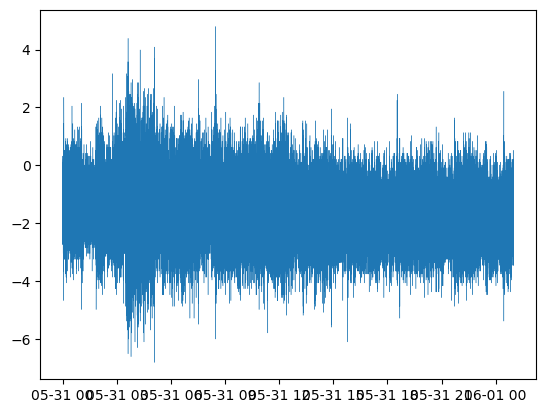

In [ ]:
Vn = read_daily_Vn( thisdt ) # the VectorNav data for this day
clf()
plot(dt, ta[:roll], linewidth=0.3)

gcf()

The chunks do not end exactly at hourly files, or even at the turnover 
of the day. A way to deal with this is 
 - Read `timeangles` in daily batches. 
 - The queried data starts at 00 of the day, and ends at the end of the day,
   or 00:00:00 of day+1.
 - Daily batches additionally include the following 00 hour of the next day 
   - This will provide for reading the
   end of the last chunk that runs into the next day.
 - Read only queried data; there will be minimal overlap for reading 
   some of the last chunk in the 00 h day+1 file.

In [8]:
# test identifying stare starts from a day of data
length(ta[:time]) # == 77024
ta[:start_time] # hourly start times
# plot(ta[:elevangle],marker=".", linestyle="none") # all stares ~90 degree elev
starestart = findall(diff(ta[:time]).>(20/3600)) .+ 1

clf()
plot(ta[:time], marker=".", markersize=0.2, linestyle="none") # hour offsets from day
plot(starestart, ta[:time][starestart], marker=".", markersize=2, color="r", linestyle="none") # hour offsets from day
# xlim([0, 7200])
# ylim([0, 2])
xlim([64000, lastien+60])
ylim([20, 25])
gcf()

UndefVarError: UndefVarError: `lastien` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [9]:
# get all the files, and all the unique hours of the files
allstarefiles = vcat( [ joinpath.("data",F, 
    filter( startswith(r"Stare_"), readdir(joinpath("data",F)) ) ) 
  for F in filter( startswith(r"20240"), readdir("data") ) ]... )

REm = match.(r"Stare_116_(\d{8}_\d{2}).hpl", allstarefiles)
dth = [ DateTime(r[1], dateformat"yyyymmdd_HH") for r in REm ]
unique(floor.(dth, Hour)) # all 991 are already unique

967-element Vector{DateTime}:
 2024-04-28T00:00:00
 2024-04-28T01:00:00
 2024-04-28T02:00:00
 2024-04-28T03:00:00
 2024-04-28T04:00:00
 2024-04-28T05:00:00
 2024-04-28T06:00:00
 2024-04-28T07:00:00
 2024-04-28T08:00:00
 2024-04-28T09:00:00
 ⋮
 2024-06-12T22:00:00
 2024-06-12T23:00:00
 2024-06-13T00:00:00
 2024-06-13T01:00:00
 2024-06-13T02:00:00
 2024-06-13T03:00:00
 2024-06-13T04:00:00
 2024-06-13T05:00:00
 2024-06-13T06:00:00

## line up mean vertical velocity with platform heave
using VectorNav - POSMV analysis in [`vectornav.ipynb`](vectornav.ipynb)

Timing between POSMV and VectorNav (VN) is determined in 
[`rot_sandbox.ipynb`](rot_sandbox.ipynb).

Use 
  - POSMV GPS time 
and 
  - VN computer time

No timing adjustments help or are needed for POSMV and VN then agree to within ~±0.5s. This applies to both legs 1 and 2.

## load data sets

Procedures will differ for different legs. 

## Timing issues

### Leg 1 
Has VectorNav data, presumably physically aligned with the coordinate system of the lidar. At least its heave is aligned with the vertical lidar beams.

VectorNav clock drifts a few seconds and then corrects, or precesses, with a 51-hour cycle, compared to the POSMV. (I said 13-h cycle, but the figure shows a ~51 h cycle.)

2025 Feb 18: The VN computer clock and POSMV GPS clocks agree. See above and 
[`rot_sandbox.ipynb`](rot_sandbox.ipynb).

!OLD!
![POSMV](./Vn-POSMV_lag.png "VectorNav-POSMV lag")

The POSMV clock runs slow compared to its own internal GPS clock.
A large time offset accumulates in leg 1.
In leg 2 the clock resets to the GPS quasi-regularly every ~2 days. 
We reconstruct the POSMV time axis
to minimize the difference with the GPS (red). 
This agrees with the VectorNav (except for 18 s GPS leapseconds).

The VectorNav time is in GPS convention and the POSMV is in UTC convention, resulting in the 18 s offset due to the GPS leapseconds.

![POSMV](./POSMV_pashr-gps.png "VectorNav-POSMV lag")

### Leg 2, part 1
There is no VectorNav data until June 4, when data starts.
There is data from the ship's POSMV. Synchronization of pitch and roll
is demonstrated in `vectornav.ipynb`.

In [ ]:
# functions for epsilon from stare w
# called in loop

# timing functions

"""
get_time_shift(mdv, heave) positive result means mdv clock is fast.
sync by subtracting this lag (in 1020 millisecods) from stare_dt.
"""
function get_time_shift(mdv, heave)
    # filter to make xcorr work better
    xc = xcorr(hp(mdv[:]), hp(heave[:]))
    # plot(-(length(mdv)-1):length(mdv)-1, xc )
    return argmax(xc) - length(mdv)
end

"hourly files -> chunk time indices"
function read_stare_time( St )
    # Lidar clock is fast (ahead) by 126832 milliseconds compared to the GPS.
    # Moving the timeseries backward (lagging the lidar) compensates its clock error.
    # adjust the lidar clock backward to agee with the GPS clock.
    lidar_clock_fast_by = Millisecond( 126832 ) # first adjustment
    stare_dt = @. (
        DateTime(Date(dt)) 
        + Millisecond(round(Int64, St[:time] * 3_600_000 )) 
        .- lidar_clock_fast_by ) # 3202

    # split into individual stare chunks
    pickets = findall( t -> t>Second(30), diff(stare_dt) )
    # st = [1; pickets.+1] # ignore start and end of file with a split chunk
    # en = [pickets; length(stare_dt)]
    st_chunk = pickets[1:end-1] .+ 1
    en_chunk = pickets[2:end]
    # subdivide into shorter chunks???
    return st_chunk, en_chunk
end

# "subdivide interval [st en] into fac even intervals"
# subdivide(st,en, fac) = round(Integer, st .+ (st-en)/fac .* [0:fac])
"subdivide single interval [st en] into fac even intervals"
subdivide(st,en, fac) = @. round(Integer, st + ((en-st)*(0:fac)/fac))
# # test
# subdivide(1,240, 4)

"read and interpolate data to stare chunks"
function read_stare_chunk(St, Vn, UV, st, en )
    # time: truncate the file's datestamp to Date, add the decimal hour
    stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(round(Int64, St[:time] * 3_600_000 )) # 3202
    lidar_clock_fast_by = Millisecond( 126832 ) # adjust for lidar clock fast (ahead) by 126832 milliseconds compared to the GPS.
    stare_dt = stare_dt_raw .- lidar_clock_fast_by

    # dopplervel (time, z) masked by intensity
    dopplervel = masklowi.(St[:dopplervel][st:en,1:ntop], St[:intensity][st:en,1:ntop])
    mdv = missmean(dopplervel, dims=2)[:] # conditional mean can have biases

    # interpolate Ur,Vr, heave to the lidar stare grid
    ind = findindices( stare_dt[st:en], Vn["time"] )
    pitch = indavg( Vn["pitch"], ind) # 11-point mean
    roll  = indavg( Vn["roll" ], ind)
    heave = indavg( Vn["heave"], ind)
    # resync the clock to the VactorNav heave - brittle
    stare1dt = stare_dt[st:en] # subset
    ind = findindices( stare1dt, Vn["time"] )
    heave = Vn["heave"][ind]
    shift = get_time_shift(mdv[:],heave[:])
    # interpolate for the updated synced time
    stare1dt .-= Millisecond((1020-80)*shift)
    ind = findindices( stare1dt, Vn["time"] ) # this works
    heave = indavg( Vn["heave"], ind)

    # mean relative velocity
    Ur = zeros(size(dopplervel))
    Vr = zeros(size(dopplervel))
    ind = findindices( Dates.value.(stare1dt), Dates.value.(UV["time"]))
    # result must be 1:1 for stare1dt and ind
    ls = length(stare1dt)
    li = length(ind)
    if li < ls # extend ind with last index of UV
        ind = [ind; length(UV["time"]).+zeros(Int32, ls-li)]
    end
    for ih in 1:ntop # loop to broadcast to consistent size
        Ur[:,ih] .= UV[:ur][ind,ih]
        Vr[:,ih] .= UV[:vr][ind,ih]
    end

    # questionable: fill all the mean relative velocities
    isf = isfinite.(Vr)
    Vr[.!isf] .= mean(Vr[isf])
    Ur[.!isf] .= mean(Ur[isf])
    
    return dopplervel, pitch, roll, heave, Ur, Vr, mdv
end

function filter_vel_coherent_heave( dopplervel, pitch, roll, heave, mdv )
    # get the component of dopplervel coherent with heave,pitch,roll
    # allowing for phase shifts
    mdv_clean_heave, _ = remove_coherent_component( Float64.(mdv), Float64.(heave) )
    mdv_remove = mdv .- mdv_clean_heave # works
    return dopplervel .- mdv_remove
end

# for testing
# seconds since dt0
"offset seconds since dt0"
toffs(dt, dt0=DateTime(2024,4,1)) = Millisecond( dt - dt0 ).value / 1000 # seconds
"datetime by adding time in seconds to dt0. Inverse of toffs"
tons(toffs, dt0=DateTime(2024,4,1)) = Millisecond(round(Int64, 1000*toffs)) + dt0

#= usage
vntoffs = toffs.( Vn["time"] )
# test indavg
vndt_int = tons.(indavg( vntoffs, ind ))
=#

function plot_stare_motcor( height, dopplervel, mdv, mdv_remove, pitch, roll, Ur, Vr)
    mm = @. minute(stare1dt) + (second(stare1dt) + millisecond(stare1dt)/1000 )/60

    clf()
    subplot(3,1,1)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("vel - mdv")
    ylim([0, 1])

    subplot(3,1,2)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv_remove)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("vel - mdv coherent with heave")
    ylim([0, 1])

    subplot(3,1,3)
    w = wtrue.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("w heave and tilt angle decompostion")
    ylim([0, 1])

    tight_layout()
    # Corrections in wtrue (other than adding the -heave) do not seem to be important
    # at this time. Motion compensation is probably working, then.
    return gcf()
end

## structure function dissipation

# stucture function constants
C2ll = 2.0
epsilon(A) = sqrt(3/4 * A/C2ll)^3
# struf(epsilon, r,r1) = C2ll * epsilon^(2/3) * r^(2/3) * (4 - (r1/r)^2)/3
# instruf(w1,w2) = (w1-w2)^2
# rho(r1,r) = r^(2/3) * (1 - ((r1/r)^2)/4)
# zmid(z1,z2) = (z1 + z2) / 2
# plot bin averaged instruf vs rho
# fit 
# D = A*rho + noise
# for A and noise
# A = 4/3 * C2ll * epsilon^(2/3)

"bin average D2 in equally-populated bins of rho"
function equal_bin(rho, D2; nbin=200, nbin_out_max=17 )
    ii = findall(.!ismissing.(rho) .& .!ismissing.(D2) )
    nrho = length(ii)
    if nrho >= 20
        sp = sortperm(rho[ii])
        srho = rho[ii][sp]
        step = max(1,round(Int32,nrho/nbin))
        rhobin = [ 0; rho[ii][sp[step:step:nrho]] ]
        jj = findall(.!ismissing.(rhobin) .& isfinite.(rhobin))
        D2inbin = binavg(D2[ii], rho[ii], rhobin[jj])
        rhoinbin = binavg(rho[ii], rho[ii], rhobin[jj])
        nbin_out = min(nbin_out_max, length(rhobin))
        return nbin_out, rhobin[1:nbin_out], D2inbin[1:nbin_out], rhoinbin[1:nbin_out]
    else
        return 1, [missing], [missing], [missing]
    end
end

"""
structure function D2, rho, A, epsilon at each level from w stare
D2bin, rhobin, A, noise = D2_rho_stare( w, pitch, roll, Ur, Vr; out=17 )
"""
function D2_rho_stare( w, pitch, roll, Ur, Vr; nbin_out_max=17 )

    nbin_out = nbin_out_max
    
    (nt, nz) = size(w)
    A      = Vector{Union{Missing,Float64}}(missing, nz)
    noise  = Vector{Union{Missing,Float64}}(missing, nz)
    rhobin = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)
    D2bin  = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)
    for izo in 1:nz # loop vertically
        #=
        ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
        zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                          pitch,roll, w; timestep=timestep )
        rho = rhopair.(dr2, dz2) # approx r^2/3
        # bin average str fcn D2 in equally-populated bins of rho
        @show size(rho), size(D2)
        rhobin_, D2inbin_, rhoinbin_ = equal_bin(rho, D2)
        rhobin[:,izo] .= rhoinbin_[1:nbin_out]
        D2bin[ :,izo] .= D2inbin_[ 1:nbin_out]
        # regress to get A
        ii = .!ismissing.(rhobin[:,izo]) .& .!ismissing.(D2bin[:,izo])
        if sum(ii) > 2
            A[izo] = anom(rhobin[:,izo][ii]) \ anom(D2bin[:,izo][ii])
            noise[izo] = mean(D2bin[:,izo][ii]) - A[izo] * mean(rhobin[:,izo][ii]) # noise
        end
        =#
        ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
        zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                          pitch,roll, w; timestep=timestep )
        rho = rhopair.(dr2, dz2) # approx r^2/3
        # bin average str fcn D2 in equally-populated bins of rho
        nbin_actual, rhobin_, D2inbin_, rhoinbin_ = equal_bin(rho, D2; nbin_out_max=nbin_out_max)
        rhobin[1:nbin_actual,izo] .= rhoinbin_
        D2bin[ 1:nbin_actual,izo] .= D2inbin_
        # regress to get A
        ii = .!ismissing.(rhobin[1:nbin_actual,izo]) .& .!ismissing.(D2bin[1:nbin_actual,izo])
        if sum(ii) > 2
            A[izo] = anom(rhobin[1:nbin_actual,izo][ii]) \ anom(D2bin[1:nbin_actual,izo][ii])
            noise[izo] = mean(D2bin[1:nbin_actual,izo][ii]) - A[izo] * mean(rhobin[1:nbin_actual,izo][ii]) # noise
        end
    end
    return D2bin, rhobin, A, noise
end


D2_rho_stare

In [11]:
# ^test D2_rho_stare line by line
#=
(nt, nz) = size(w)
nbin_out_max = 17
A      = Vector{Union{Missing,Float64}}(missing, nz)
noise  = Vector{Union{Missing,Float64}}(missing, nz)
rhobin = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)
D2bin  = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)

izo = 1
    ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
    zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                      pitch*pi/180,roll*pi/180, w; timestep=timestep ) #hacked
    rho = rhopair.(dr2, dz2) # approx r^2/3
    # bin average str fcn D2 in equally-populated bins of rho
    nbin_actual, rhobin_, D2inbin_, rhoinbin_ = equal_bin(rho, D2; nbin_out_max=nbin_out_max)
    rhobin[1:nbin_actual,izo] .= rhoinbin_
    D2bin[ 1:nbin_actual,izo] .= D2inbin_
    # regress to get A
    # this is a mess because the bins can be of different sizes, 
    # resulting in different quality estimates of epsilon
    ii = .!ismissing.(rhobin[1:nbin_actual,izo]) .& .!ismissing.(D2bin[1:nbin_actual,izo])
    if sum(ii) > 2
        A[izo] = anom(rhobin[1:nbin_actual,izo][ii]) \ anom(D2bin[1:nbin_actual,izo][ii])
        noise[izo] = mean(D2bin[1:nbin_actual,izo][ii]) - A[izo] * mean(rhobin[1:nbin_actual,izo][ii]) # noise
    end
=#

## Compute TKE dissipation in ~10 min chunks by hour

In [12]:
# line by line test one chunk

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )

lidardaydir = lidardaydirs[2]
dt = Date(lidardaydir, dateformat"yyyymmdd")

epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

Vn = read_daily_Vn( dt )            # Dict
# load daily relative horizontal winds
UV = get_daily_meanuv( dt )

lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[21]
splt = split(lidarfile, r"[_.]")
dt = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime

St, _ = read_streamlinexr_stare( dt )
height = St[:height][1:ntop]
# TO DO: read the next hour to get continuous chunk at end ...
st_chunks, en_chunks = read_stare_time( St )
ichunk = 5
st = st_chunks[ichunk]
    en = en_chunks[ichunk]
    # read a chunk
    dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( St, Vn, UV, st, en )
    # cannot consistently sync heave and dopplervel
    #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
    w = dopplervel .- mdv 
    # subplot(2,1,1)
    # pcolormesh(pd(m2n.(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
    epsi_tmp[ichunk,:] = @. epsilon(max(0,A))

    subplot(2,1,1)
    plot(m2n.(rhobin), m2n.(D2bin), marker=".", linewidth=0.4)
    xlim([0, 50])
    ylim([0, 0.2])


(0.0, 0.2)

In [13]:
# test: compute dissipation for one hour

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "/Users/deszoeks/Data/EKAMSAT/lidar" # "./data/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )

lidardaydir = lidardaydirs[5]
dt = Date(lidardaydir, dateformat"yyyymmdd")

epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

Vn = read_daily_Vn( dt )            # Dict
# load daily relative horizontal winds
UV = get_daily_meanuv( dt )

lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[12]
dt = Date(lidardaydir, dateformat"yyyymmdd")
epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

Vn = read_daily_Vn( dt )            # Dict
# load daily relative horizontal winds
UV = get_daily_meanuv( dt )

lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[12]
splt = split(lidarfile, r"[_.]")
dt = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime

St, _ = read_streamlinexr_stare( dt )
height = St[:height][1:ntop]
# TO DO: read the next hour to get continuous chunk at end ...
st_chunks, en_chunks = read_stare_time( St )
for (ichunk, st) in enumerate(st_chunks)
    en = en_chunks[ichunk]
    # read a chunk
    dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( St, Vn, UV, st, en )
    if any(isfinite.(Ur)) && any(isfinite.(Vr))
        # cannot consistently sync heave and dopplervel
        #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
        w = dopplervel .- mdv 
        D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
        epsi_tmp[ichunk,:] = @. epsilon(max(0,A))
    end
end


In [14]:
# loop through lidar data and compute TKE dissipation rate

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )
epsi = Matrix{Union{Missing,Float64}}(missing, 6*24*60, ntop)
# lidardtstart = zeros(6*24*60)
# lidardtend = zeros(6*24*60)

# compute epsilon for all stares # commented out
#=

# for lidardaydir in lidardaydirs[2:16] # files available leg 1
for lidardaydir in lidardaydirs[2:6] # files available leg 1
# for lidardaydir in lidardaydirs[17:end] # files available leg 2
    dt = Date(lidardaydir, dateformat"yyyymmdd") # a Date
    print("$(lidardaydir) ")
    # can't sync motion with clock!
    try # load daily vectornav  
        Vn = read_daily_Vn( dt )            # Dict
    catch
        print("no VectorNav for $(dt)")
    end
    try # load daily relative horizontal winds
        UV = get_daily_meanuv( dt )         # NCDataset
    catch
        print("no mean wind for $(dt)\n")
        #save epsilon.jld2 just in case
        # jldopen("epsilon_tmp.jld2", "w+") do file
        #     file["epsilon"] = epsi
    end

    # load hourly lidar stares
    bigind = 0 # index time, save daily
    for lidarfile in filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))
        splt = split(lidarfile, r"[_.]")
        dt = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime
        print("$(splt[4]) ")
        
        St, _ = read_streamlinexr_stare( dt )
        height = St[:height][1:ntop]
        # TO DO: read the next hour to get continuous chunk at end ...
        st_chunks, en_chunks = read_stare_time( St )
        stare_dt = @. ( dt 
            + Millisecond(round(Int64, St[:time] * 3_600_000 )) 
            - lidar_clock_fast_by )
        for (ichunk, st) in enumerate(st_chunks)
            en = en_chunks[ichunk]
            bigind += 1
            # read a chunk
            dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( St, Vn, UV, st, en )
            if any(isfinite.(Ur)) && any(isfinite.(Vr))
                # cannot consistently sync heave and dopplervel
                #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
                w = dopplervel .- mdv 
                D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
                epsi[bigind,:] .= @. epsilon.(max(0,A))
            else
                epsi[bigind,:] .= -4 # code for missing wind
            end
            lidardtstart[bigind] = stare_dt[st]
            lidardtend[bigind] = stare_dt[en]
        end
    end
    print("\n")
    #save data daily to epsilon.jld2
    fileout = "epsilon_$(Dates.format(dt, dateformat"yyyymmdd")).jld2"
    print("Saving $(fileout)\n")
    jldopen(fileout, "w+") do file
        file["epsilon"] = epsi[1:bigind,:]
        file["start_dt"] = lidardtstart[1:bigind]
        file["end_dt"]   = lidardtend[1:bigind]
    end
end
=#

# notes
# heave channel constant on 2024-5-12
# no mean wind on 2024-05-12
# 20240519 no VectorNav for 2024-05-19 00

8640×80 Matrix{Union{Missing, Float64}}:
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing  …  missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing  missing
 ⋮                                   ⋱                             
 missing  missing  missing  missing     missing  missing  missing  missing
 missing  missing  missing  missing     missing  missing  missing 

In [1]:
# just compute and save start and end times for stares

lidar_clock_fast_by = Millisecond( 126832 ) # ~2 minutes; check this!

lidardtstart = Vector{DateTime}(undef, 6*24*60)
lidardtend = Vector{DateTime}(undef, 6*24*60)

# for lidardaydir in lidardaydirs[2:16] # files available leg 1
for lidardaydir in lidardaydirs[2:4] # files available leg 1
        # for lidardaydir in lidardaydirs[17:end] # files available leg 2
    dt = Date(lidardaydir, dateformat"yyyymmdd") # a Date
    print("$(lidardaydir) ")
    # can't sync motion with clock!
    try # load daily vectornav  
        Vn = read_daily_Vn(dt)            # Dict
    catch
        print("no VectorNav for $(dt)")
    end
    try # load daily relative horizontal winds
        UV = get_daily_meanuv(dt)         # NCDataset
    catch
        print("no mean wind for $(dt)\n")
        #save epsilon.jld2 just in case
        # jldopen("epsilon_tmp.jld2", "w+") do file
        #     file["epsilon"] = epsi
    end

    # load hourly lidar stares
    bigind = 0 # index time, save daily and reset bigind daily
    # read each hour in the day
    for lidarfile in filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir, lidardaydir)))
        splt = split(lidarfile, r"[_.]")
        dt = DateTime(splt[3] * splt[4], dateformat"yyyymmddHH") # a DateTime
        print("$(splt[4]):")

        # read 1 hour
        St, _ = read_streamlinexr_stare(dt)
        st_chunks, en_chunks = read_stare_time(St)
        stare_dt = @. ( dt 
            + Millisecond(round(Int64, St[:time] * 3_600_000 )) 
            - lidar_clock_fast_by )
        for (ichunk, st) in enumerate(st_chunks) # find time of each chunk
            en = en_chunks[ichunk]
            bigind += 1
            lidardtstart[bigind] = stare_dt[st]
            lidardtend[bigind]   = stare_dt[en]
        end
    end
    print("\n")
    #save data daily to epsilon.jld2
    fileout = "staredt_$(Dates.format(dt, dateformat"yyyymmdd")).jld2"
    print("Saving $(fileout)\n")
    jldopen(fileout, "w") do file
        file["start_dt"] = lidardtstart[1:bigind]
        file["end_dt"]   = lidardtend[1:bigind]
    end
end

UndefVarError: UndefVarError: `Millisecond` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing Dates in the current active module Main

In [31]:
jldopen("./epsilon_data/epsilon_tmp.jld2", "r") do file
    epsi = file["epsilon"]
end

pcolormesh(pd(m2n.(epsi)))

PyObject <matplotlib.collections.QuadMesh object at 0x34d60cd60>

In [142]:
# Tests

# check that St and Vn data are synced
clf()
subplot(2,1,1)
plot(hp(mdv))
plot(hp(heave))
xlim([400, 440])
# check lags
xc = xcorr( hp(mdv[:]), hp(heave) )
subplot(2,1,2)
plot( -(length(mdv)-1):length(mdv)-1, xc )
xlim([-40, 40])
#length(xc), 2*(length(mdv)-1) + 1
argmax(xc) - length(mdv) # 0-lag center moved to 0
# length(xc), length(mdv), 2*length(heave)


plot(mdv)
# plot(mdv_clean_heave)
# plot(mdv_clean_heavepitch)
# plot(mdv_clean_heavepitch)


plot(stare1dt, heave)
plot(stare1dt, mdv)
plot(stare1dt, mdv - heave) # subtract heave because its downward

UndefVarError: UndefVarError: `stare1dt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## prepare the structure function analysis

In [ ]:
clf()
subplot(2,1,1)
plot(rhobin, D2bin, marker="*")
plot([0, 2.2*mean(rhobin[1:17])], noise .+ A.*[0, 2.2*mean(rhobin[1:17])])
xlim([0, 30])
xlabel(L"\rho = r^{2/3}"
title("TKE dissipation = 1.4 $\times 10^{-4}$")
epsilon(A) # 1.3e-4

LoadError: UndefVarError: `clf` not defined